## Classification
We could try to classify different stations to leisure / work traffic. 

A leisure station would be a station which as compared to the other stations high traffic on weekend days, while having lower traffic on weekdays.

This assumes that on weekends people do not work, which is mostly the case.

The goal is to classify the different station as leisure / utilatarian or mixed.

In [224]:
from data_io.loader.data_loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

dl = DataLoader()

In [225]:
AM = (6,10)
MID = (10,16)
PM = (16,19)
EVE = (16,24)

station = "Plöck"
interval_summer = ("2022-04-01", "2022-07-01")
interval_winter = ("2021-11-01", "2022-02-01")

Daily mean count $\bar{C}_{24h}$: Sum of daily ```channels_out```, then mean of this sum.

In [226]:
def daily_mean_count(loader, station_name, interval=None):
    df = loader.get_bicycle(
        station_name,
        interval=interval,
        sample_rate="1d"
    ).df.mean()

    return df["channels_all"].item()

daily_mean_count(loader=dl, station_name=station)

4167.55800775425

How large is the hourly mean count for a station? (f.ex. 0h: 24, 1h: 20, 2h: 18, ...)

Calculating Hourly mean: Sum of counts per hour / 24 hours and normalizing over overall daily mean $\bar{C}_{24h}$ to make stations comparable. 

Therefore:
$$
\begin{align*}
I_{h} = \frac{\bar{C}_{1h}}{\bar{C}_{24h}}
\end{align*}
$$

One would assume we get a general trend that later at night we get low counts, morning mid-day we get high counts. 

In [227]:
def hourly_index(loader, station_name, interval=None, weekday=None):
    df = loader.get_bicycle(
        station_name, interval=interval, sample_rate="1h"
    ).filter_time(weekday=weekday).df

    mean_C_24h = daily_mean_count(loader, station_name, interval)

    Ih = (
        df
        .with_columns([
            pl.col("datetime").dt.hour().alias("hour"),
        ])
        .group_by("hour")
        .agg(pl.mean("channels_all").alias("mean_C_1h"))
        .with_columns((pl.col("mean_C_1h") / mean_C_24h).alias("I_h"))
        .sort("hour")
    )
    return Ih

hourly_index(loader=dl, station_name=station)

hour,mean_C_1h,I_h
i8,f64,f64
0,19.627098,0.004709
1,12.916767,0.003099
2,8.23674,0.001976
3,7.469565,0.001792
4,17.485603,0.004196
…,…,…
19,159.473495,0.038265
20,130.726101,0.031368
21,99.647526,0.02391


How large is the daily mean count for a station? (f.ex. 1st: 246, 2nd: 223, 3rd: 201, ...)

Calculating Daily mean: Sum of counts per day / 24 hours and normalizing over overall daily mean $\bar{C}_{24h}$ to make stations comparable.

Therefore:
$$
\begin{align*}
I_{d} = \frac{\bar{C}_{1d}}{\bar{C}_{24h}}
\end{align*}
$$

In [228]:
def daily_index(loader, station_name, interval=None, weekday=None):
    df = loader.get_bicycle(
        station_name,
        interval=interval,
        sample_rate="1d"
    ).filter_time(weekday=weekday).df

    mean_C_24h = daily_mean_count(loader, station_name, interval)

    Id = (
        df.with_columns([
            pl.col("datetime").dt.weekday().alias("weekday"),
        ])
        .group_by("weekday")
        .agg(pl.mean("channels_all").alias("mean_C_1d"))
        .with_columns((pl.col("mean_C_1d") / mean_C_24h).alias("I_d"))
        .sort("weekday")
    )
    return Id
daily_index(loader=dl, station_name=station)

weekday,mean_C_1d,I_d
i8,f64,f64
1,4488.417537,1.07699
2,4886.343096,1.172472
3,4865.460417,1.167461
4,4825.135699,1.157785
5,4372.377358,1.049146
6,3544.770355,0.850563
7,2199.517672,0.527771


How large is the monthly mean count for a station? (f.ex. January: 2463, February: 2231, ...)

Calculating Monthly mean: Sum of counts per month / 30 days and normalizing over overall daily mean $\bar{C}_{24h}$ to make stations comparable. 

Therefore:
$$
\begin{align}
I_{d} = \frac{\bar{C}_{1d}}{\bar{C}_{24h}}
\end{align}
$$

In [229]:
def monthly_index(loader, station_name, interval=None, weekday=None):
    df = loader.get_bicycle(
        station_name,
        interval=interval,
        sample_rate="30d"
    ).filter_time(weekday=weekday).df

    mean_C_24h = daily_mean_count(loader, station_name, interval)

    Im = (
        df
        .with_columns([
            pl.col("datetime").dt.month().alias("month"),
        ])
        .group_by("month")
        .agg(pl.mean("channels_all").alias("mean_C_30d"))
        .with_columns((pl.col("mean_C_30d") / mean_C_24h).alias("I_m"))
        .sort("month")
    )

    return Im

monthly_index(loader=dl, station_name=station)

month,mean_C_30d,I_m
i8,f64,f64
1,105189.0,25.239961
2,91443.2,21.941674
3,109435.6,26.258927
4,133650.6,32.069284
5,146196.555556,35.079669
…,…,…
8,109482.666667,26.27022
9,122054.0,29.286695
10,122072.9,29.29123


In [230]:
def plot_hourly_profiles(
    loader,
    station_name,
    interval=None,
    figsize=(10, 4),
    ylim=None
):
    Ih_weekday = hourly_index(
        loader, station_name, interval=interval, weekday=True
    )
    Ih_weekend = hourly_index(
        loader, station_name, interval=interval, weekday=False
    )

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # weekday
    axes[0].plot(
        Ih_weekday["hour"],
        Ih_weekday["I_h"],
        linewidth=2
    )
    axes[0].set_title("Weekday")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel("Hourly Index $I_h$")
    axes[0].grid(alpha=0.3)

    # weekend
    axes[1].plot(
        Ih_weekend["hour"],
        Ih_weekend["I_h"],
        linewidth=2
    )
    axes[1].set_title("Weekend")
    axes[1].set_xlabel("Hour")
    axes[1].grid(alpha=0.3)

    if ylim is not None:
        axes[0].set_ylim(ylim)

    fig.suptitle(f"Hourly Profiles – {station_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

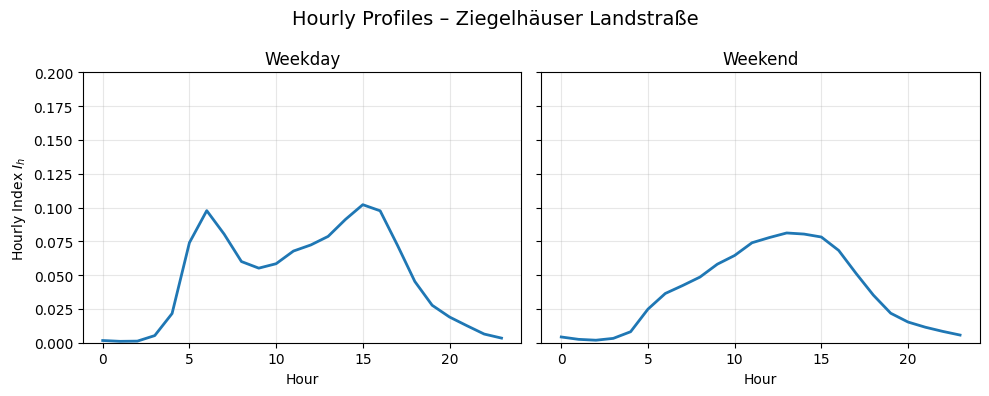

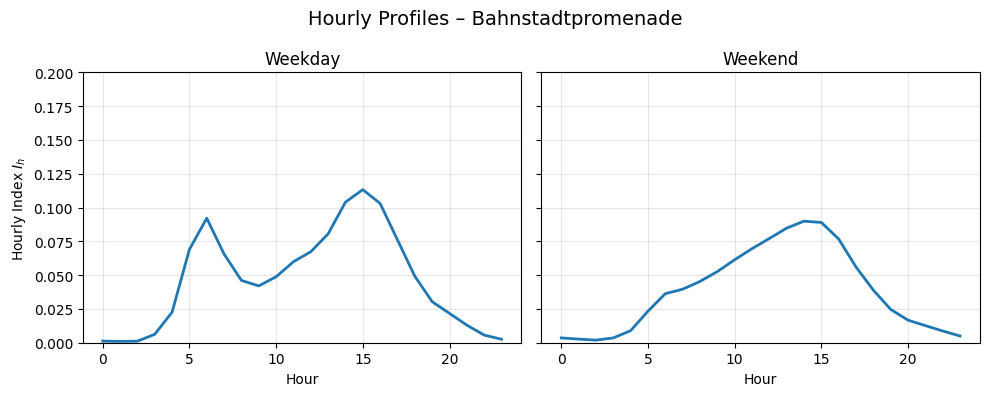

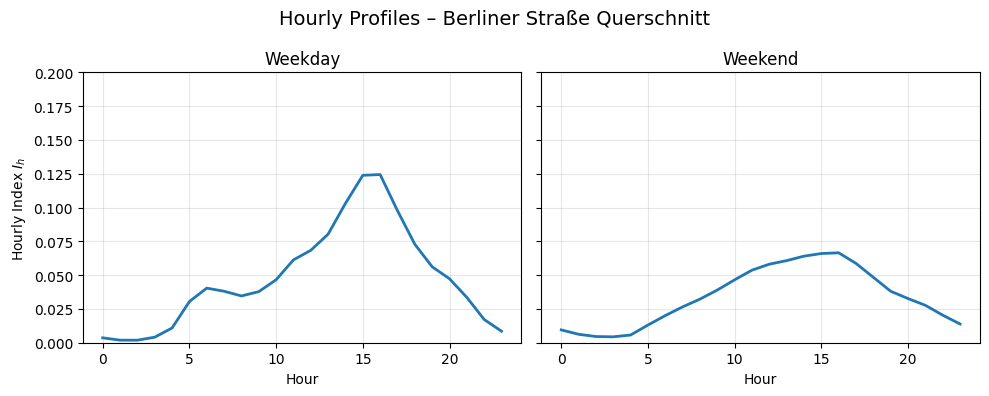

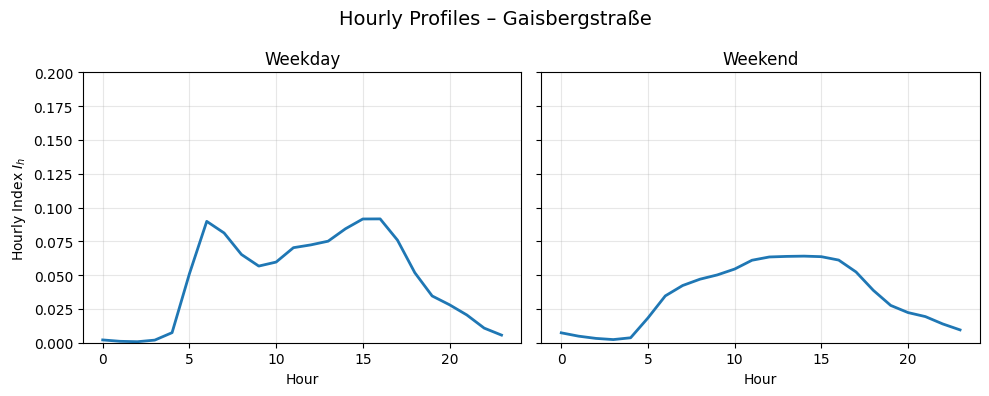

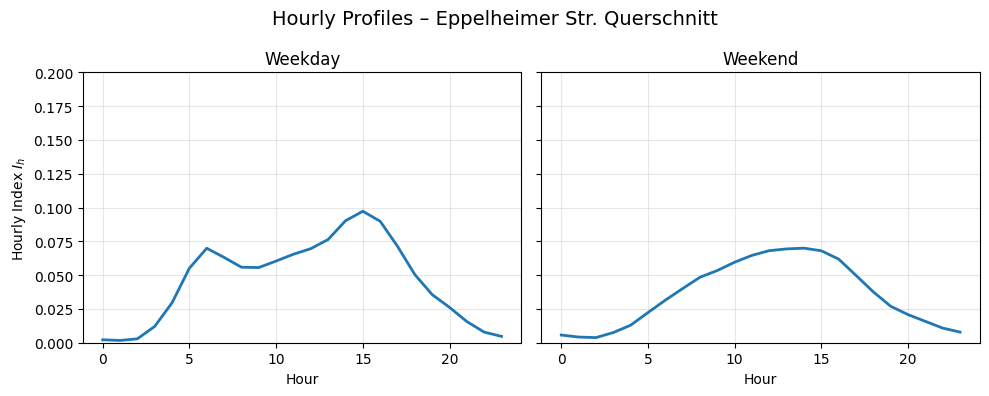

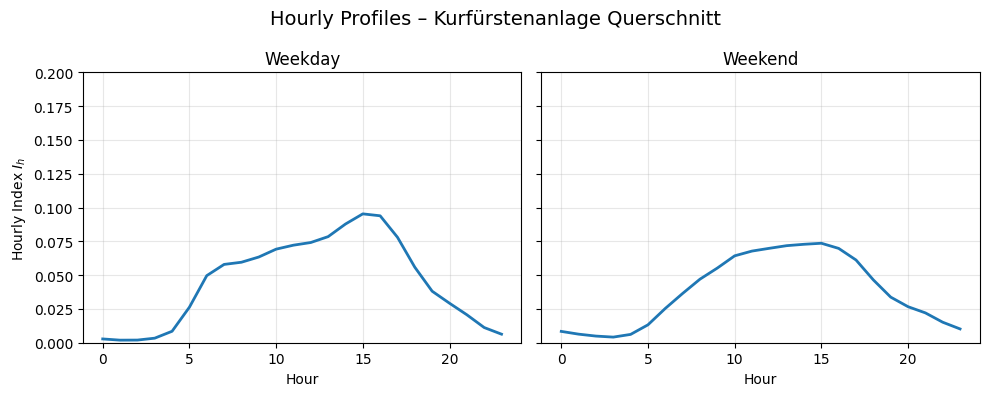

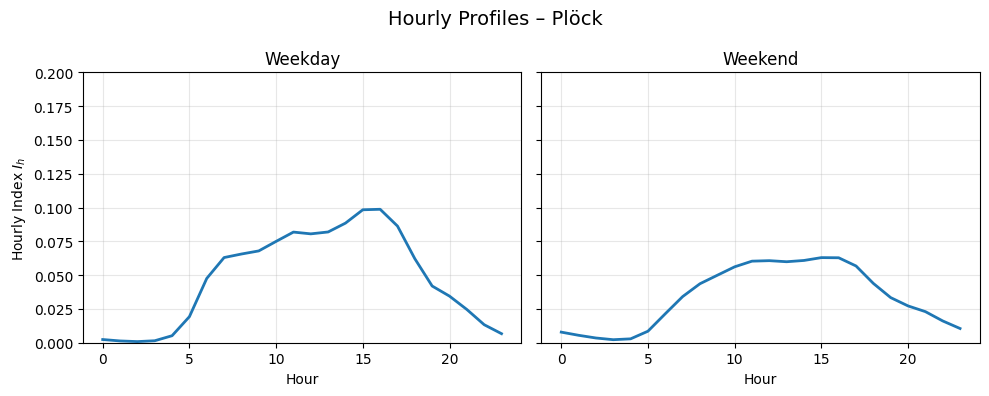

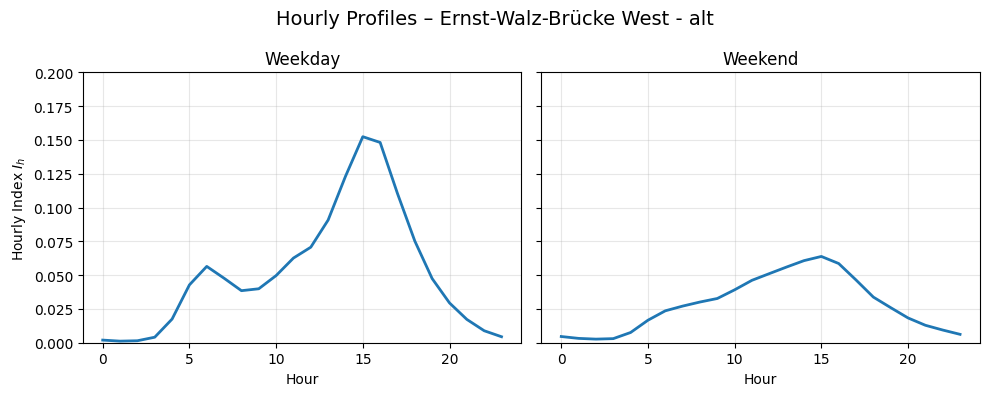

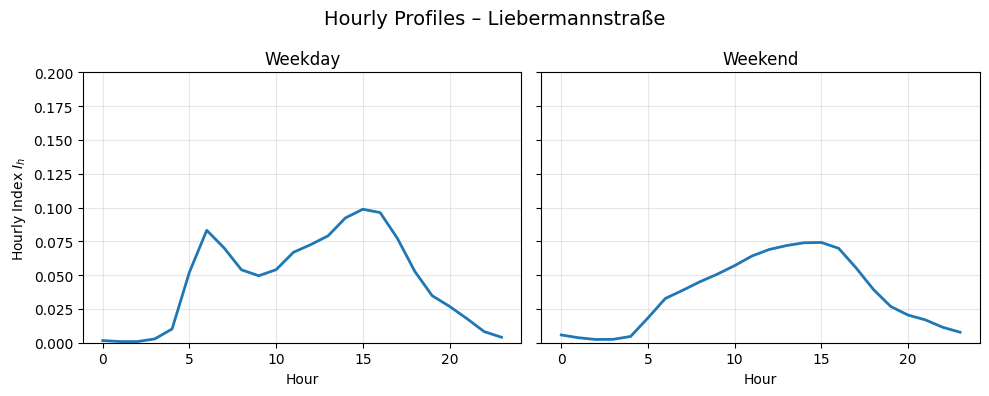

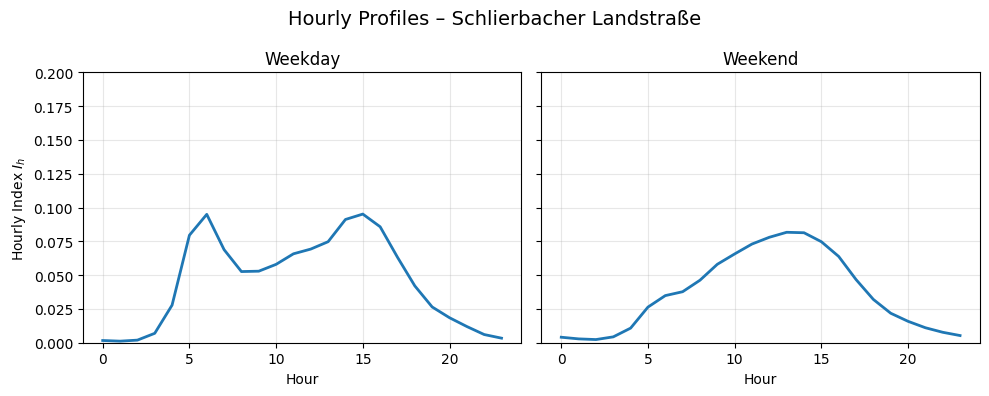

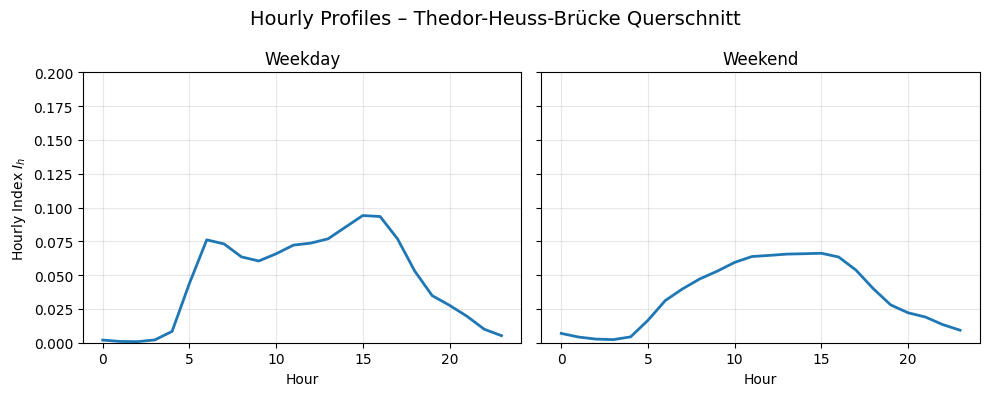

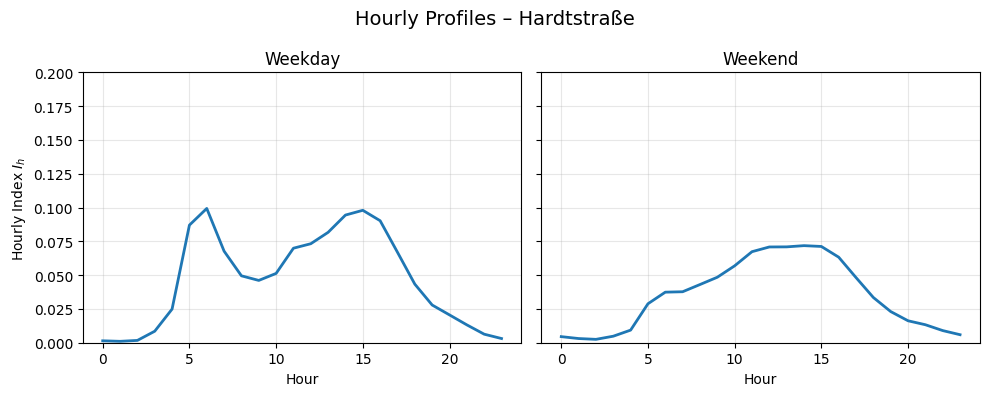

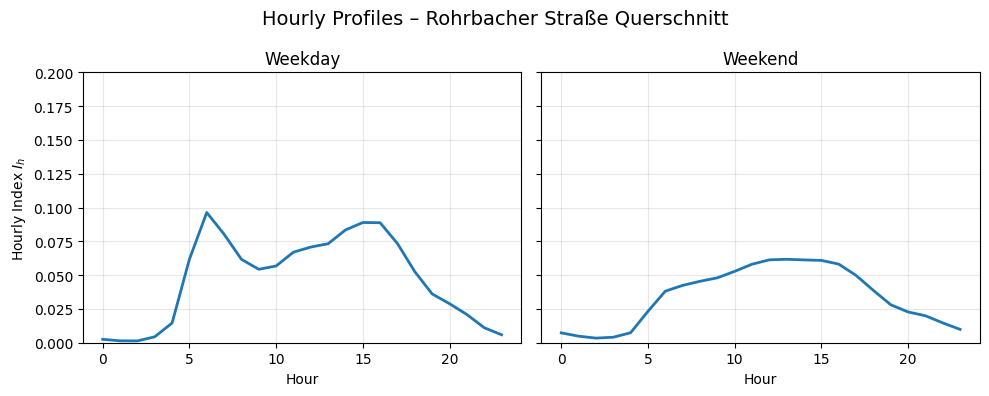

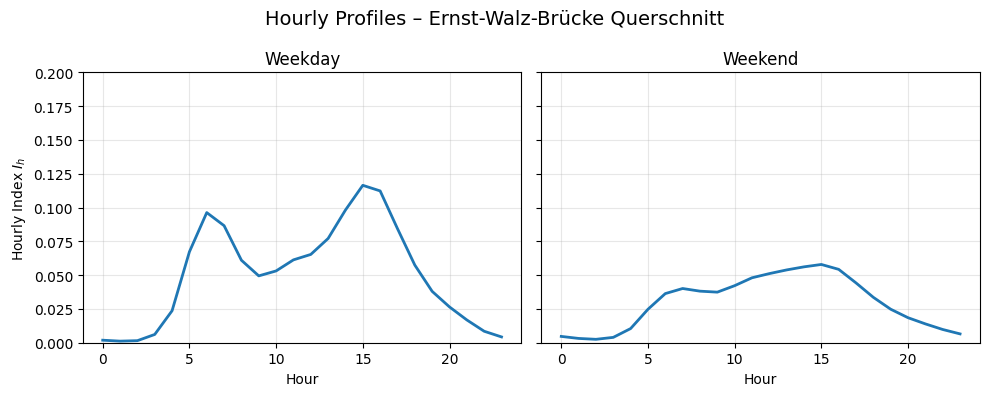

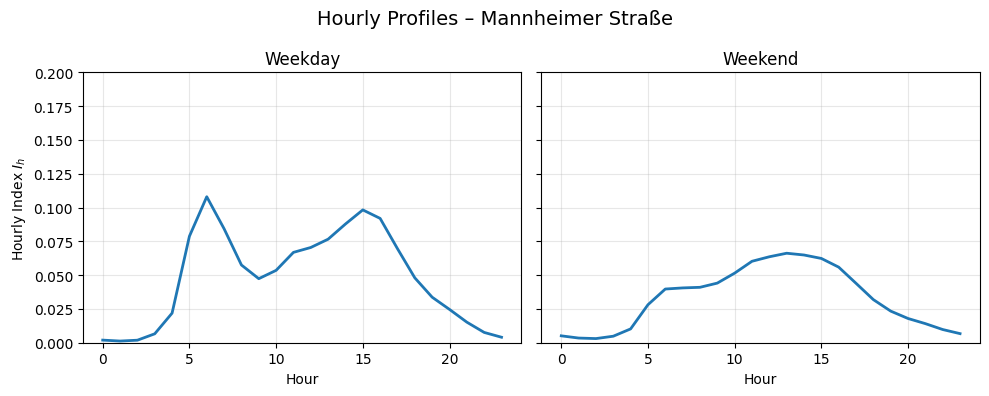

In [231]:
for station in dl.get_bicyle_stations():
  plot_hourly_profiles(loader=dl, station_name=station, interval=None, ylim=(0, 0.2))

In [232]:
def plot_daily_profile(loader, station_name, interval=None, ylim=None):
    Id = daily_index(loader, station_name, interval=interval)

    plt.figure(figsize=(6, 3))
    plt.plot(
        Id["weekday"],
        Id["I_d"],
        marker="o",
        linewidth=2
    )

    plt.xticks(
        ticks=range(1,8),
        labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    )

    plt.title(f"Daily Profile – {station_name}")
    plt.ylabel("Daily Index $I_d$")
    plt.grid(alpha=0.3)

    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

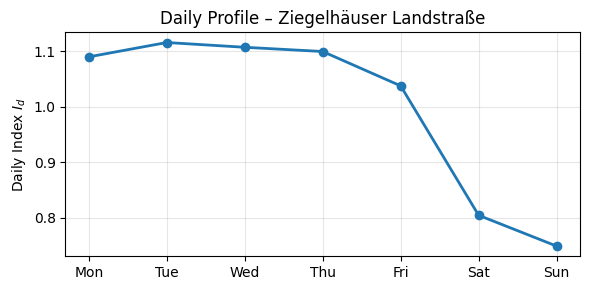

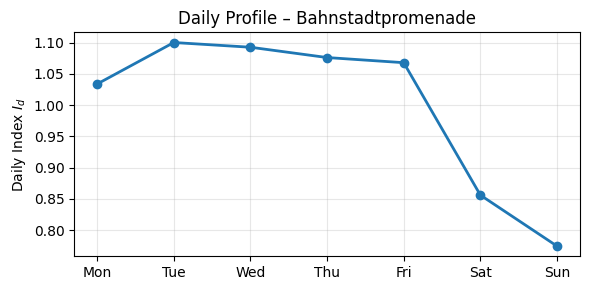

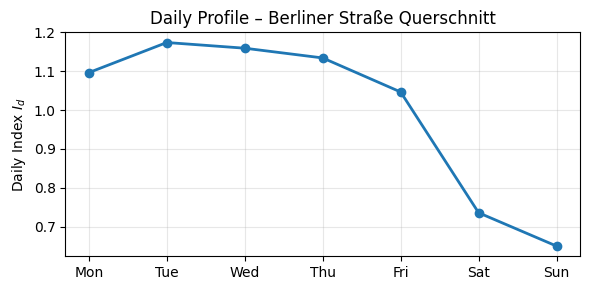

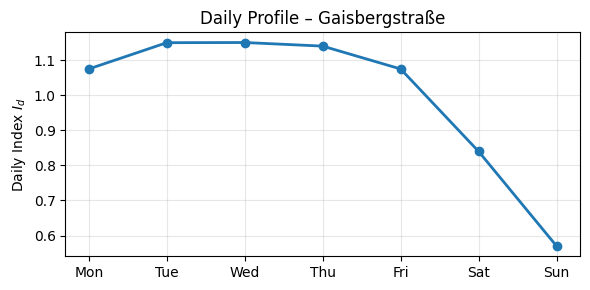

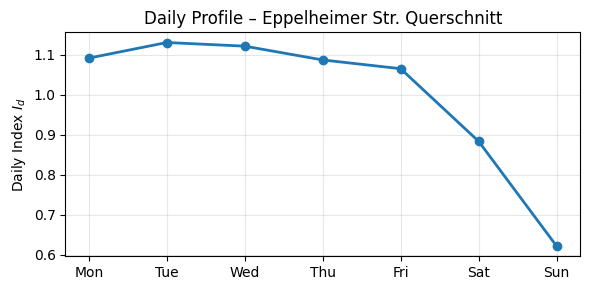

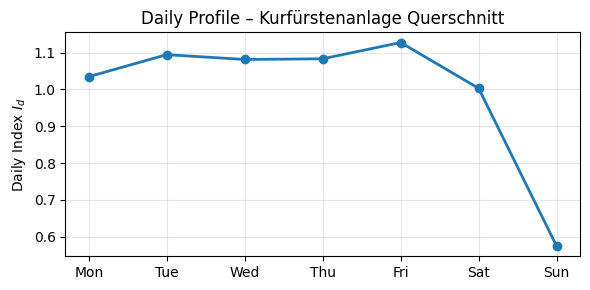

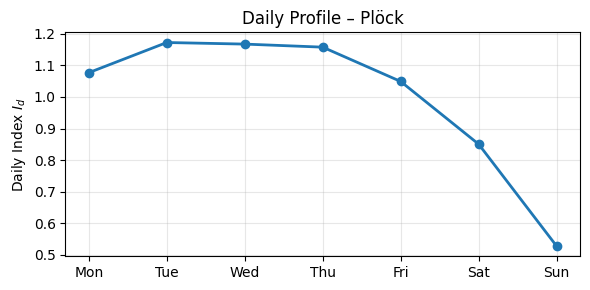

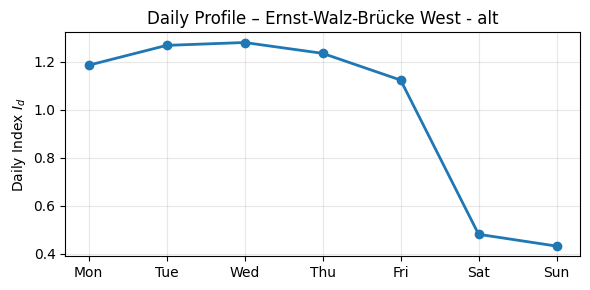

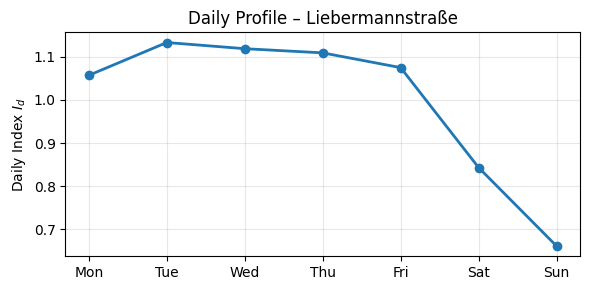

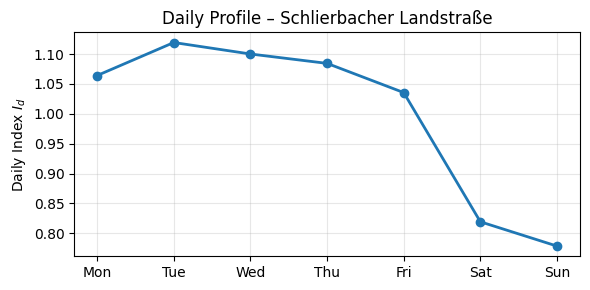

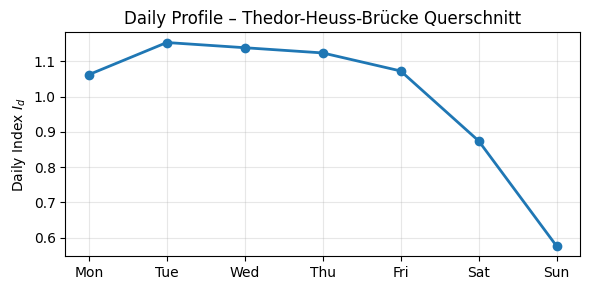

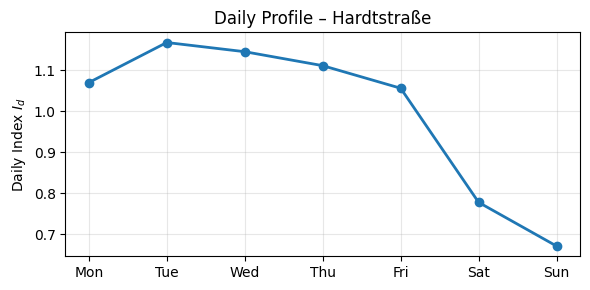

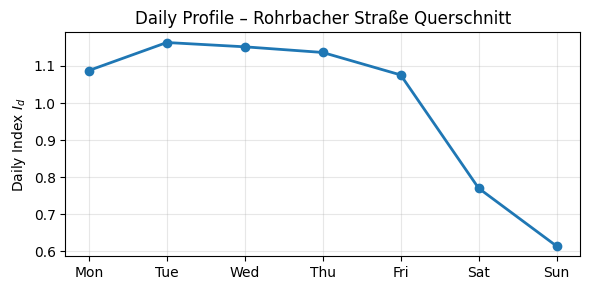

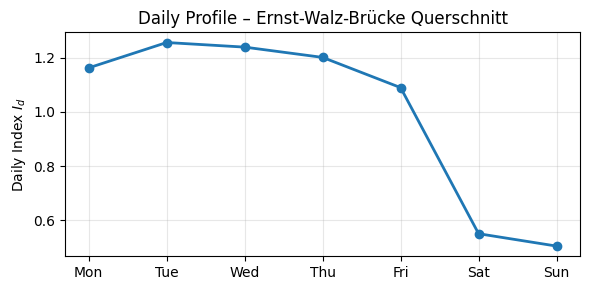

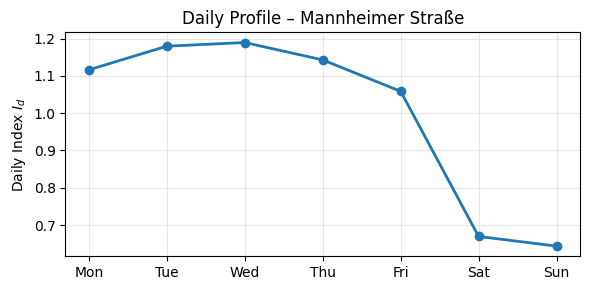

In [233]:
for s in dl.get_bicyle_stations():
    plot_daily_profile(dl, s)

In [234]:
def plot_monthly_profile(loader, station_name, interval=None, ylim=None):
    Im = monthly_index(loader, station_name, interval=interval)

    plt.figure(figsize=(6, 3))
    plt.plot(
        Im["month"],
        Im["I_m"],
        marker="o",
        linewidth=2
    )

    plt.xticks(
        ticks=range(1, 13),
        labels=["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]
    )

    plt.title(f"Monthly Profile – {station_name}")
    plt.ylabel("Monthly Index $I_m$")
    plt.grid(alpha=0.3)

    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

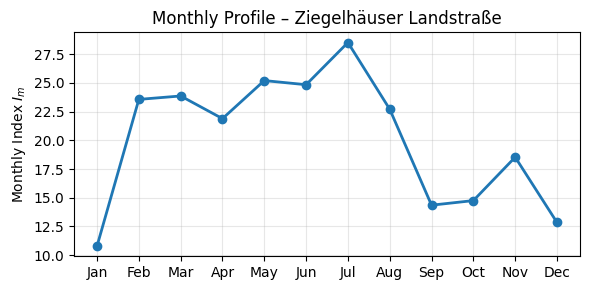

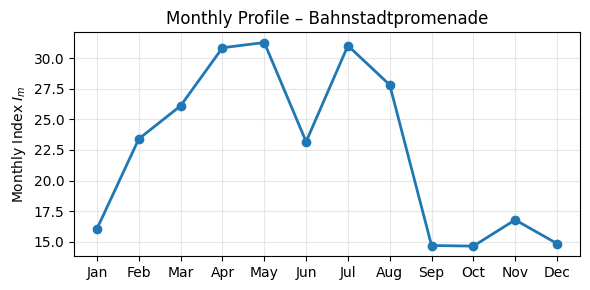

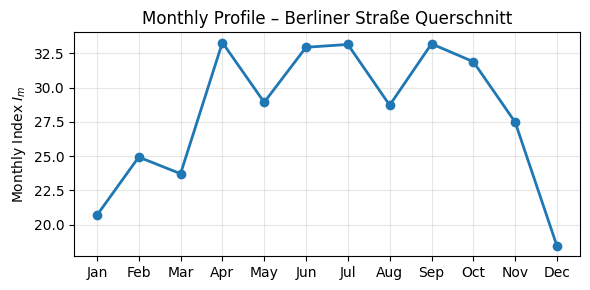

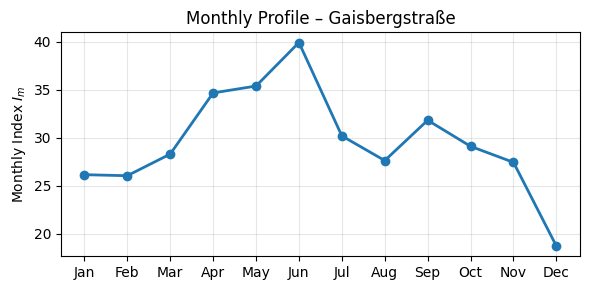

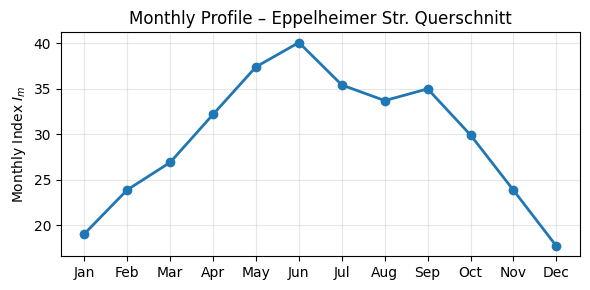

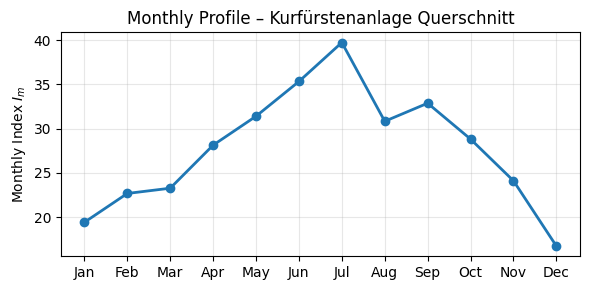

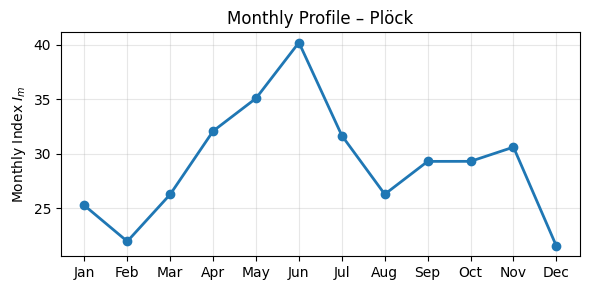

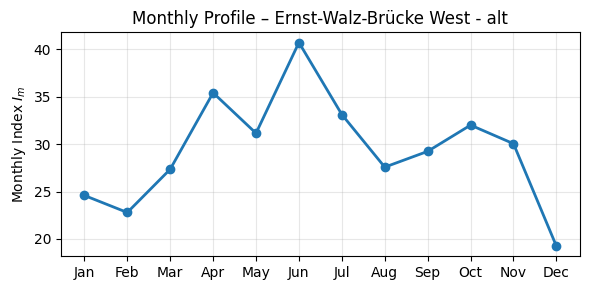

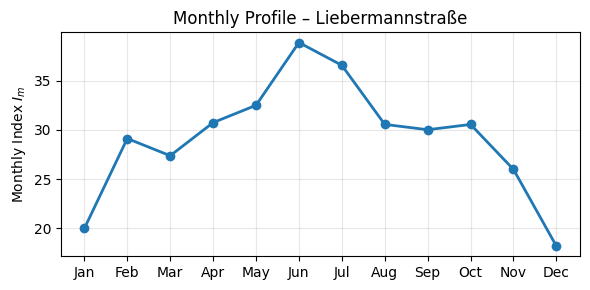

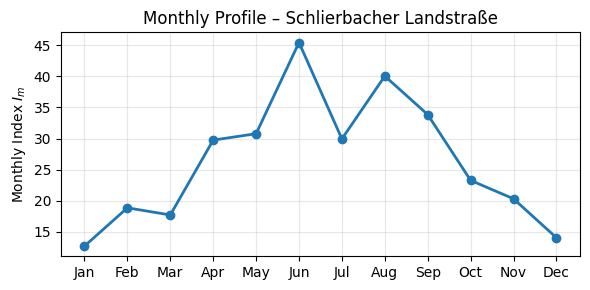

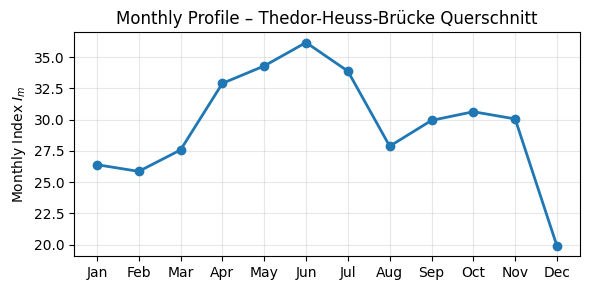

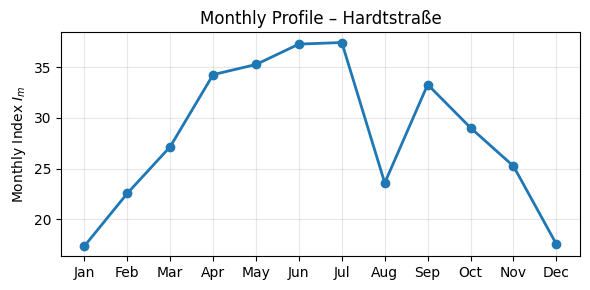

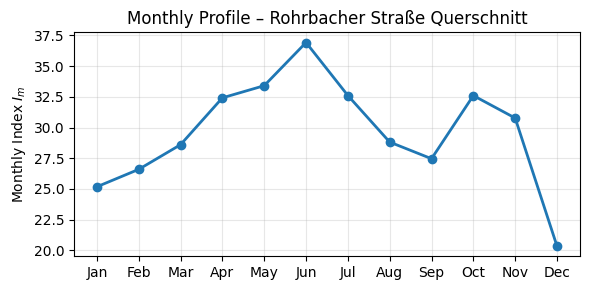

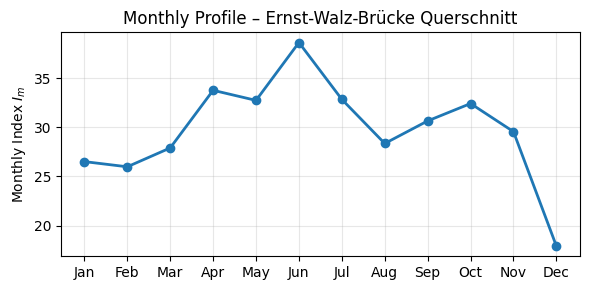

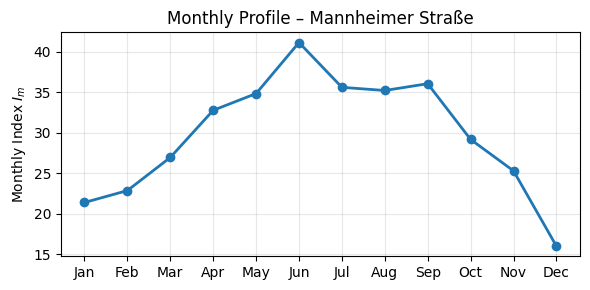

In [235]:
for s in dl.get_bicyle_stations():
    plot_monthly_profile(dl, s)

### Features
Since we want to classify the stations, we will build a feature vector which holds discriminators between leisure and 
utilitarian counting stations.

In [236]:
def mean_Ih_in_window(Ih, hour_min, hour_max):
    return (
        Ih
        .filter(
            (pl.col("hour") >= hour_min) &
            (pl.col("hour") < hour_max)
        )
        .select(pl.mean("I_h"))
        .item()
    )


def build_station_features(loader, station_name, interval=None):
    Ih_wd = hourly_index(loader, station_name, interval, weekday=True)
    Ih_we = hourly_index(loader, station_name, interval, weekday=False)

    Id = daily_index(loader, station_name, interval)

    Im = monthly_index(loader, station_name, interval)

    features = {
        # Hourly 
        # Utilitarian: AM => High Traffic (Work)
        # Leisure: AM => Low Traffic
        "wd_AM": mean_Ih_in_window(Ih_wd, *AM),
        "wd_PM": mean_Ih_in_window(Ih_wd, *PM),
        "we_MID": mean_Ih_in_window(Ih_we, *MID),
        "we_EVE": mean_Ih_in_window(Ih_we, *EVE),

        # Daily
        # Utilitarian: Weekday => High Traffic
        # Leisure: Weekday => Low Traffic
        "Id_weekday": (
            Id.filter(pl.col("weekday") <= 4)
              .select(pl.mean("I_d"))
              .item()
        ),
        "Id_weekend": (
            Id.filter(pl.col("weekday") >= 5)
              .select(pl.mean("I_d"))
              .item()
        ),

        # Monthly
        # Utilitarian: Winter => Higher Traffic
        # Leisure: Winter => Low Traffic
        "Im_summer": (
            Im.filter(pl.col("month").is_in([6, 7, 8]))
              .select(pl.mean("I_m"))
              .item()
        ),
        "Im_winter": (
            Im.filter(pl.col("month").is_in([11, 12, 1, 2]))
              .select(pl.mean("I_m"))
              .item()
        ),
    }

    return features


In [237]:
def build_feature_df(loader, interval=None):
    rows = []
    for station in loader.get_bicyle_stations():
        feats = build_station_features(loader, station, interval)
        feats["station"] = station
        rows.append(feats)

    return pl.DataFrame(rows)

In [238]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = build_feature_df(dl)

X_num = X.drop("station").to_numpy()
X_scaled = StandardScaler().fit_transform(X_num)

### K-Means
Applying K-Means with two clusters (Utilitarian, Leisure)

- Cluster 0: Utilitarian
- Cluster 1: Leisure

In [239]:
kmeans_2 = KMeans(n_clusters=2, random_state=0, n_init=20)
labels_2 = kmeans_2.fit_predict(X_scaled)

X_k2 = X.with_columns(pl.Series("cluster_k2", labels_2))
X_k2

X_k2.group_by("cluster_k2").mean()

cluster_k2,wd_AM,wd_PM,we_MID,we_EVE,Id_weekday,Id_weekend,Im_summer,Im_winter,station
i32,f64,f64,f64,f64,f64,f64,f64,f64,str
1,0.059479,0.097959,0.052182,0.026069,1.227551,0.696859,33.538153,24.582095,null
0,0.064485,0.074578,0.066812,0.030358,1.115692,0.845609,33.123426,21.656696,null


and with three clusters (Utilitarian, Leisure, Mixed):

- Cluster 0: Leisure
- Cluster 1: Mixed
- Cluster 2: Utilitarian

In [240]:
kmeans_3 = KMeans(n_clusters=3, random_state=0, n_init=20)
labels_3 = kmeans_3.fit_predict(X_scaled)

X_k3 = X.with_columns(pl.Series("cluster_k3", labels_3))
X_k3

X_k3.group_by("cluster_k3").mean()


cluster_k3,wd_AM,wd_PM,we_MID,we_EVE,Id_weekday,Id_weekend,Im_summer,Im_winter,station
i32,f64,f64,f64,f64,f64,f64,f64,f64,str
2,0.064377,0.071432,0.071925,0.029251,1.097061,0.870504,32.993799,19.514715,null
0,0.041673,0.104767,0.055502,0.032355,1.191125,0.744863,32.707167,23.527987,null
1,0.070547,0.07598,0.059739,0.029555,1.149571,0.800564,33.551652,24.507044,null


### PCA
Reducing ```X_scaled``` with 8 dimensions to 2

In [241]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance:", pca.explained_variance_ratio_)

X_pca_pl = (
    X_k3
    .with_columns([
        pl.Series("PC1", X_pca[:, 0]),
        pl.Series("PC2", X_pca[:, 1]),
    ])
)


Explained variance: [0.50269299 0.23522675]


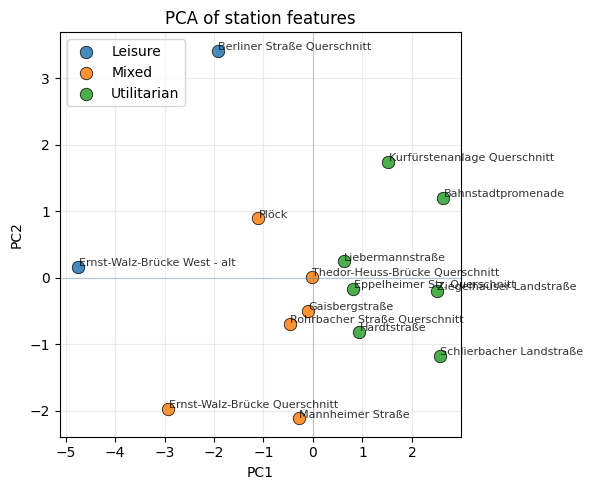

In [242]:
def plot_pca_clusters(
    df,
    pc1="PC1",
    pc2="PC2",
    cluster_col="cluster_k3",
    label_col="station",
    annotate=True,
    figsize=(6, 5),
    alpha=0.85,
    point_size=80
):
    
    label_map = {
        0: "Leisure",
        1: "Mixed",
        2: "Utilitarian"
    }
    
    plt.figure(figsize=figsize)

    clusters = sorted(df[cluster_col].unique())

    for c in clusters:
        df_c = df.filter(pl.col(cluster_col) == c)

        plt.scatter(
            df_c[pc1].to_numpy(),
            df_c[pc2].to_numpy(),
            s=point_size,
            alpha=alpha,
            label=label_map.get(c, f"Cluster {c}"), 
            edgecolors="black",
            linewidths=0.6
        )

    if annotate:
        for row in df.iter_rows(named=True):
            plt.text(
                row[pc1] + 0.01,
                row[pc2] + 0.01,
                row[label_col],
                fontsize=8,
                alpha=0.8
            )

    plt.axhline(0, linewidth=0.8, alpha=0.3)
    plt.axvline(0, linewidth=0.8, alpha=0.3)

    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.title("PCA of station features")
    plt.legend(frameon=True)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_pca_clusters(
    X_pca_pl,
    cluster_col="cluster_k3",
    annotate=True
)

- Cluster 0: Utilitarian
- Cluster 1: Mixed
- Cluster 2: Leisure

In [243]:
CLUSTER_COLORS = {
    0: "blue",
    1: "green",
    2: "red",
}


import folium


def add_cluster_legend(m):
    legend_html = """
     <div style="
     position: fixed;
     bottom: 40px;
     left: 40px;
     z-index: 9999;
     background-color: white;
     padding: 10px;
     border: 2px solid grey;
     border-radius: 5px;
     font-size: 14px;
     ">
     <b>Station type</b><br>
     <i style="background: blue; width: 10px; height: 10px; float: left; margin-right: 6px;"></i>
     Leisure<br>
     <i style="background: green; width: 10px; height: 10px; float: left; margin-right: 6px;"></i>
     Mixed<br>
     <i style="background: red; width: 10px; height: 10px; float: left; margin-right: 6px;"></i>
     Utilitarian
     </div>
     """
    m.get_root().html.add_child(folium.Element(legend_html))


def bicycle_station_cluster_map(loader, cluster_df, cluster_col):
    stations = loader.get_bicyle_stations()

    lats, lons = [], []
    for s in stations:
        lat, lon = loader.get_bicycle_location(s)
        lats.append(lat)
        lons.append(lon)

    m = folium.Map(
        location=[sum(lats)/len(lats), sum(lons)/len(lons)],
        zoom_start=13
    )

    for s, lat, lon in zip(stations, lats, lons):
        cluster = (
            cluster_df
            .filter(pl.col("station") == s)
            .select(cluster_col)
            .item()
        )

        color = CLUSTER_COLORS.get(cluster, "gray")

        folium.CircleMarker(
            location=[lat, lon],
            radius=7,
            color=color,
            fill=True,
            fill_opacity=0.9,
            popup=f"{s}<br>Cluster {cluster}"
        ).add_to(m)

    return m


m_k3 = bicycle_station_cluster_map(dl, X_k3, "cluster_k3")
add_cluster_legend(m_k3)
m_k3